# K-Drama Ratings on MyDramaList.com
K-Dramas have become increasingly popular with successful hits and increased accessibility in international markets. Having enjoyed K-Dramas for a long time, I have become acquainted with the Asian drama review site [MyDramaList](https://www.mydramalist.com). I often use this site for determining my next binge based on the average rating. I would like to try to predict the average rating for a drama and find out what predictor has the greatest effect. Full project code can be found [here](https://github.com/alau88/kdrama-public).

## Data Collection
For this project, I will look into the past decade of K-Dramas on this site (2012-2022). Since they no longer support an API, I created a webscrapper `MDL_scrape.py`. I scraped all dramas in the range, which amounted to 100 pages on the website. This dataset is saved in a file `MDL Data.csv`.

First I will load the dataset. Note that names include the site's tags since there are individuals with the same romanized name. 

In [602]:
import pandas as pd
df = pd.read_csv("MDL_Data_2012_2022.csv")
df.head(5)

,Rank,URL,Title,Country,Air Date,Time Slot,Episodes,Runtime,Network,Director,Writer,Leads,Leads_Likes,Leads_Max,Score,Voter,Watchers,Genre,Tag
0,0,https://mydramalist.com/18452-goblin/cast,Goblin,South Korea,"Dec 2, 2016 - Jan 21, 2017","Friday, Saturday",16,1 hr. 22 min.,tvN,/people/16030-lee-eung-bok,/people/15905-kim-eun-sook,"/people/440-gong-yoo, /people/2599-kim-go-eun,...",7919.80,11700,8.8,98472,185456,"Comedy, Romance, Fantasy, Melodrama","Supernatural, Older Man/Younger Woman, Intersp..."
1,1,https://mydramalist.com/18894-strong-woman-do-...,Strong Woman Do Bong Soon,South Korea,"Feb 24, 2017 - Apr 15, 2017","Friday, Saturday",16,1 hr. 7 min.,jTBC,/people/17370-lee-hyung-min,/people/16545-baek-mi-kyeong,"/people/1498-park-bo-young, /people/3014-park-...",8541.00,10998,8.7,98831,171949,"Action, Comedy, Romance, Supernatural","Strong Female Lead, Female Lead Action Scenes,..."
2,2,https://mydramalist.com/10904-descendants-of-t...,Descendants of the Sun,South Korea,"Feb 24, 2016 - Apr 14, 2016","Wednesday, Thursday",16,60 min.,KBS2,"/people/16019-baek-sang-hoon, /people/16030-le...","/people/15905-kim-eun-sook, /people/16024-kim-...","/people/431-song-joong-ki, /people/294-song-hy...",6197.50,14160,8.7,82240,156781,"Action, Comedy, Romance, Melodrama","Hardworking Female Lead, Multiple Couples, Bro..."
3,3,https://mydramalist.com/19262-weightlifting-fa...,Weightlifting Fairy Kim Bok Joo,South Korea,"Nov 16, 2016 - Jan 11, 2017","Wednesday, Thursday",16,60 min.,MBC,"/people/15983-oh-hyun-jong, /people/23550-nam-...","/people/15982-yang-hee-seung, /people/17756-ki...","/people/7660-lee-sung-kyung, /people/7714-nam-...",5032.75,12066,8.8,87503,156300,"Comedy, Romance, Life, Sports","Weightlifting, Friends To Lovers, Strong Femal..."
4,4,https://mydramalist.com/16589-w/cast,W,South Korea,"Jul 20, 2016 - Sep 14, 2016","Wednesday, Thursday",16,60 min.,MBC,/people/15943-jung-dae-yoon,/people/15942-song-jae-jung,"/people/300-han-hyo-joo, /people/900-lee-jong-suk",12345.50,20227,8.5,80496,150027,"Thriller, Comedy, Romance, Fantasy","Parallel Dimension, Gun Violence, Crossworlds ..."


I will remove dramas with less than 1000 watchers, as the ratings on those can be heavily biased. This reduces the number of entries closer to 1000.

In [603]:
print(df.shape)
df = df[df['Watchers']>1000]
print(df.shape)

(1990, 19)
(1255, 19)


The airdate needs to be separated into the premiere and finale dates. The runtime will also need to be converted into a workable format of minutes.

In [604]:
df[['Premiere','Finale']] = df['Air Date'].str.split(" - ",expand=True)
df.drop(columns=['Air Date'], inplace=True)
df.head(30)
df['Premiere'] = pd.to_datetime(df['Premiere'])
df['Finale'] = pd.to_datetime(df['Finale'])
df.Finale.fillna(value=df.Premiere,inplace=True) #Single release will have none for finale --> take value from neighbour
df.dropna(inplace=True,subset=['Runtime'])#Runtimes of n/a will be dropped since they also have no data for other fields
df['Runtime'] = df['Runtime'].str.replace(" hr.", '*60').str.replace(' min.','*1').str.replace(' ','+').apply(eval)#convert runtime into minutes
df.head(1)

C:\Users\anson\AppData\Local\Temp\ipykernel_5260\1183516124.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Runtime'] = df['Runtime'].str.replace(" hr.", '*60').str.replace(' min.','*1').str.replace(' ','+').apply(eval)#convert runtime into minutes


,Rank,URL,Title,Country,Time Slot,Episodes,Runtime,Network,Director,Writer,Leads,Leads_Likes,Leads_Max,Score,Voter,Watchers,Genre,Tag,Premiere,Finale
0,0,https://mydramalist.com/18452-goblin/cast,Goblin,South Korea,"Friday, Saturday",16,82,tvN,/people/16030-lee-eung-bok,/people/15905-kim-eun-sook,"/people/440-gong-yoo, /people/2599-kim-go-eun,...",7919.8,11700,8.8,98472,185456,"Comedy, Romance, Fantasy, Melodrama","Supernatural, Older Man/Younger Woman, Intersp...",2016-12-02,2017-01-21


Many dramas are listed under multiple genres. Since I want genre as a feature, I will extracted the nested data from the column using one-hot encoding. Given the large number of tags (>1000) that exist, this process will not be applied to the tags and this category will be dropped as a feature later.

In [605]:
df['Genre'].fillna('0', inplace = True) #Fill in any NaNs
g= pd.DataFrame(df['Genre'].str.split(',')) #Turn nested data into list
h = pd.get_dummies(pd.DataFrame(g['Genre'].tolist()).stack()).sum(level=0) #One-hot encoding
df.drop(columns=['Genre'],inplace=True) #Replace category
df = pd.concat([df, h], axis=1, join='inner') #Inner join
df.head(1)

C:\Users\anson\AppData\Local\Temp\ipykernel_5260\3278196209.py:3: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  h = pd.get_dummies(pd.DataFrame(g['Genre'].tolist()).stack()).sum(level=0) #One-hot encoding


,Rank,URL,Title,Country,Time Slot,Episodes,Runtime,Network,Director,Writer,...,Horror,Law,Life,Military,Music,Mystery,Psychological,Romance,Thriller,Youth
0,0,https://mydramalist.com/18452-goblin/cast,Goblin,South Korea,"Friday, Saturday",16,82,tvN,/people/16030-lee-eung-bok,/people/15905-kim-eun-sook,...,0,0,0,0,0,0,0,0,0,0


## Trends

For this section, I will look into some general trends and the relationships between features.

### Webdramas

The average length of dramas in the dataset decreases from 2012 onwards. This trend can be explained by the rise of [webdramas](https://journals.sagepub.com/doi/10.1177/13678779211014532). These shortform dramas are hosted on sites such as Youtube and Naver TV Cast. There have been many sucessful channels in this space, notably 72 secs, Playlist, King of Kdrama (KoK), and WhyNot. These webdramas tend to be short (~15 min) as they are usually consumed on mobile devices during [breaks and commutes](https://www.koreatimes.co.kr/www/news/culture/2015/02/201_173333.html). We can expect to see a fall in the number of webdramas from 2020 onwards due to the COVID-19 pandemic restrictions in South Korea.

In [606]:
from bokeh.io import output_notebook, show, output_file, export_png
from bokeh.plotting import figure
import numpy as np
from bokeh.io import output_notebook, show, output_file, export_png
from bokeh.plotting import figure
from math import pi # will use it for claculating angles when drawing pie charts in Bokeh
from bokeh.transform import cumsum, factor_cmap # also to be used in Bokeh pie charts
from bokeh.palettes import Category20, Spectral5, Spectral
from bokeh.models import ColumnDataSource
from bokeh.layouts import gridplot
from bokeh.models.formatters import NumeralTickFormatter

avg_run_df = pd.DataFrame(df.groupby(df.Premiere.dt.year)['Runtime'].mean()).reset_index()
avg_run_source = ColumnDataSource(avg_run_df)
avg_run_p = figure(height=350, title='Mean Runtime', toolbar_location=None, tools="")
avg_run_p.vbar(x='Premiere', top='Runtime', source=avg_run_source, width=0.5)
avg_run_p.xaxis.axis_label = 'Year'
avg_run_p.yaxis.axis_label = 'Mean Runtime (min)'
avg_run_p.y_range.start = 0

web_test = df[df['Tag'].str.contains('Web Series',na = False)]
count_df = pd.DataFrame(web_test.groupby(web_test.Premiere.dt.year)['Runtime'].count()).reset_index()
count_source = ColumnDataSource(count_df)
count_p = figure(height=350, title='Webdramas', toolbar_location=None, tools="")
count_p.vbar(x='Premiere', top='Runtime', source=count_source, width=0.5)
count_p.xaxis.axis_label = 'Year'
count_p.yaxis.axis_label = 'Count'
count_p.y_range.start = 0

grid_web = gridplot([avg_run_p, count_p], ncols=2, width=500, height=500)
output_notebook()
show(grid_web)

Loading BokehJS ...

### Networks

The network share is another interesting point. The selection of 2012 as the start date for the dataset accounts for the fact that the cable networks were allowed in 2012 due to the deregulation of broadcasting in South Korea.
Sorting the networks by type, we can also see the rise in Over-the-top (OTT) services such as Netflix. These networks produce their own content and also license content for broadcast internationally. Mnet, Naver TV Cast, and vLive are broadcast webdramas which are lower budget but also feature younger casts and k-idols.

In [607]:
df['Network'].fillna('Web', inplace=True)
net_data = df['Network'].str.split(pat = ", ",expand=True).stack().value_counts()
#print(net_data)
net_counts = net_data.iloc[:19]
net_counts.loc['Other'] = net_data.iloc[19:].sum()
#Only take the top 19, throw rest into other category
nets = pd.Series(net_counts).reset_index(name='value').rename(columns={'index': 'Network'})
#NA = web --> disney+ whynot/youtube, viki, tving, waave, youtube premium
net = net_data.reset_index(name='value').rename(columns={'index': 'Network'})
net_dict = {'KBS2':'Terrestrial', "KBS1":"Terrestrial", "SBS":"Terrestrial", "MBC":"Terrestrial", 
"tvN":"Cable", "jTBC":"Cable", "OCN":"Cable", "TV Chosun":"Cable", "MBN":"Cable", "Channel A":"Cable", "ENA":"Cable", 
"SBS Plus":"Cable", "Mnet":"Cable", "On Style":"Cable", "MBC Dramanet":"Cable", "DRAMACube":"Cable", "E-Channel":"Cable", 
"O'live":"Cable", "SUPER ACTION":"Cable", "MBC QueeN":"Cable", "XtvN":"Cable", "Tooniverse":"Cable", "CGV":"Cable",
"Netflix":"OTT", "Naver TV Cast":"Web", "Viki":"OTT", "Web":"Web", "Daum Kakao TV":"Web", 
"vLive":"Web", "iQiyi":"OTT", "ViuTV":"OTT", "MBC every1":"OTT", "Oksusu":"OTT", "DramaX":"OTT", 
"Hulu":"OTT", "LINE TV":"OTT", "Sohu TV":"OTT", "Tencent Video":"OTT", "Olleh TV":"OTT", 
"Amazon Prime":"OTT",  "AbemaTV":"OTT",  "BS Japan":"OTT"}
net['Type'] = net['Network'].map(net_dict)
#print(net.groupby(['Type', 'Network'])['value'].sum())
net_type = net.drop(columns=["Network"])
pie_chart = net_type.groupby(by='Type').sum()
pie_chart['angle'] = pie_chart['value']/pie_chart['value'].sum() * 2*pi
pie_chart['color'] = Category20[len(pie_chart)]

p = figure(height=400, title="Network Share by Type with Watchers > 1000", toolbar_location=None,
           tools="hover", tooltips="@Type: @value", x_range=(-0.5, 1.0))

p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='Type', source=pie_chart)
p.axis.axis_label = None
p.axis.visible = False
p.grid.grid_line_color = None

output_notebook()
show(p)


Loading BokehJS ...

We can look at the evolution of network share by type over time. The following two graphs show the rise in OTT content as well as the diminishing share in terrestial networks, which can be partially explained by the stricter censorship they face.  Terrestial and cable networks produce nearly the same number of dramas year to year as they are based on available airing slots. The data is not of **all** dramas but the ones with watchers > 1000 in the past 10 years. Cable dramas have seen a steady increase until they stabilized due to their introduction. OTT/Webdramas gain increasingly at the cost of cable and terrestial dramas. OTT channels have greater access in terms of subtitles and subject to less censorship. All foreign OTT services like Netflix and Disney+ have been making inroads. It can be seen that OTT content performs better on MyDramaList, partially due to the higher international accessibility of services such as Netflix, Viki, and Hulu. Mnet, Naver TV Cast, and vLive are broadcast webdramas which are lower budget but also feature younger casts and k-idols. These tend to have lower views and many have been removed by filtering out entries with less than 1000 watchers.

In [608]:
stack_data = df.drop(columns=["Rank", "URL","Country","Title","Time Slot"]) #Title	Country	Time Slot	Episodes	Runtime	Network	Director	Writer	Leads	Score	Voter	Watchers	Genre	Tag	Premiere	Finale
stack_data['Network'] = df['Network'].fillna('Web')
stack_data = stack_data.assign(Network=df['Network'].str.split(', ')).explode('Network') #Double networks should be split
#print(stack_data)
stack_data['Type'] = stack_data['Network'].str.extract('(%s)' % '|'.join(net_dict.keys())) #Match with dictionary without exact match using join A|B
stack_data['Type'] = stack_data['Type'].map(net_dict)
#New dataframes keeping rows with watchers > x # of viewers
stack_data1000 = stack_data[stack_data['Watchers'] > 1000]
stack_data10000 = stack_data[stack_data['Watchers'] > 10000]
#Taking grouping to get desired Year --> Type --> Count and then unstacking to structure data for bokeh stacked plots
stack2 = stack_data1000.groupby([stack_data1000.Premiere.dt.year,"Type"])['Network'].size().unstack().fillna(0)
stack3 = stack_data10000.groupby([stack_data10000.Premiere.dt.year,"Type"])['Network'].size().unstack().fillna(0)
stack2.index = stack2.index.map(str)
stack3.index = stack3.index.map(str)
years = stack2.index.to_list()
#types = stack1.columns.tolist()
types= ['Terrestrial','Cable','OTT','Web']
typing= ['PTerrestrial','PCable','POTT','PWeb']
colors = Category20[len(types)]
#Add percentages, keep counts for tooltip
stack2['Total'] = stack2['Terrestrial'] + stack2['Cable'] + stack2['OTT'] + stack2['Web']
stack2[typing] = stack2[types].divide(stack2['Total'], axis=0) #Convert to proportion
stack3['Total'] = stack3['Terrestrial'] + stack3['Cable'] + stack3['OTT'] + stack3['Web']
stack3[typing] = stack3[types].divide(stack3['Total'], axis=0) #Convert to proportion
graph2 = ColumnDataSource(stack2)
graph3 = ColumnDataSource(stack3)
tooltips = [
    ("Year", "@Premiere"),
    ("Terrestrial", "@Terrestrial"),
    ("Cable", "@Cable"),
    ("OTT", "@OTT"),
    ("Web", "@Web")
]
#>1000
s2 = figure(x_range=years, height=600, title="Evolution of KDrama Formats (Watchers > 1000)",toolbar_location=None, tools="", tooltips=tooltips)

s2.vbar_stack(typing, x='Premiere', width=0.5, color=colors, source=graph2, legend_label=types)

s2.y_range.start = 0
s2.x_range.range_padding = 0.1
s2.xgrid.grid_line_color = None
s2.axis.minor_tick_line_color = None
s2.outline_line_color = None
s2.legend.location = "bottom_left"
s2.legend.orientation = "horizontal"
s2.yaxis.formatter = NumeralTickFormatter(format='0 %')
s2.xaxis.major_label_orientation = pi/4
s2.xaxis.axis_label = 'Year'
s2.yaxis.axis_label = 'Share'
#>10000
s3 = figure(x_range=years, height=600, title="Evolution of KDrama Formats (Watchers > 10000)",toolbar_location=None, tools="", tooltips=tooltips)

s3.vbar_stack(typing, x='Premiere', width=0.5, color=colors, source=graph3, legend_label=types)

s3.y_range.start = 0
s3.x_range.range_padding = 0.1
s3.xgrid.grid_line_color = None
s3.axis.minor_tick_line_color = None
s3.outline_line_color = None
s3.legend.location = "bottom_left"
s3.legend.orientation = "horizontal"
s3.yaxis.formatter = NumeralTickFormatter(format='0 %')
s3.xaxis.major_label_orientation = pi/4
s3.xaxis.axis_label = 'Year'
s3.yaxis.axis_label = 'Share'

# make a grid
grid = gridplot([s2, s3], ncols=2, width=500, height=500)

output_notebook()
show(grid)

Loading BokehJS ...

This chart shows the number of dramas with more than 1000 watchers by network, giving a more detailed look into the success of each network internationally.

In [609]:
share = stack_data.groupby(['Network','Type'])['Premiere'].size().fillna(0).sort_values(ascending=False).reset_index()
share=share.set_index('Network')
ntwrk = share.index.to_list()
#types = testing.columns.tolist()
types= ['Terrestrial','Cable','OTT/Web']
color_dict = {'Terrestrial':colors[0], "Cable":colors[1], "OTT":colors[2], 'Web':colors[3]}
share['Color'] = share['Type'].map(color_dict)
tooltips1 = [
    ("Network", "@Network"),
    ("Type", "@Type"),
    ("Count", "@Premiere")
]
p = figure(height=400, title="Network Share", toolbar_location=None,
           tools="", tooltips=tooltips1, x_range=ntwrk, width = 1000)

p.vbar(x='Network', top='Premiere', source=share, width=0.5, color='Color', legend_field="Type")
p.xaxis.major_label_orientation = pi/4
p.title.text ='Network Share in Top 1000'
p.xaxis.axis_label = 'Network'
p.yaxis.axis_label = 'Count'

p.xgrid.grid_line_color = None
p.y_range.start = 0
output_notebook()
show(p)

Loading BokehJS ...

## Exploratory Data Analysis

### Ratings
The ratings from MyDramaList go from 0-10. However, this dataset only contains values between 5.8-10. The majority of the ratings are centered around fall between 6-8. This narrow range will likely have a negative effect on the model. It is surprising that the dramas are so well received. A possibility is that only promising dramas are chosen for international distribution.

In [610]:
ratings = df['Score']
ratings_data = df['Score'].describe()
print(ratings_data)
p = figure(height=600, title="Ratings", toolbar_location=None,
           tools="", width = 800, x_range=(0,10), y_range=(0,1))
bins = np.linspace(0, 10, 30)
hist, edges = np.histogram(ratings, density=True, bins=bins)
p.title.text ='Viewer Ratings'
p.xaxis.axis_label = 'Rating'
p.yaxis.axis_label = 'Occurence'
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
         fill_color="skyblue", line_color="white")
output_notebook()
show(p)

count    1251.000000
mean        7.768026
std         0.549866
min         5.800000
25%         7.400000
50%         7.800000
75%         8.200000
max        10.000000
Name: Score, dtype: float64


Loading BokehJS ...



### Feature Correlation

Selecting features is an important step. Attention should be spared for multicollinearity which could affect the model. Certain categories can be dropped and should not be selected as features. These include the categories of `'Rank','Time Slot','URL','Title', 'Country'` since they are not relevant to an international audience. Furthermore the exact day of airing for the dramas are not important. This can be reduced down to the year of broadcast instead. `'Tag'` will also be dropped as there are >1000 tags with each drama having multiple tags as well. Names will be encoded for the model. The lead actors' names will also be dropped as the amount of likes their profiles have are a much better quantitative feature. Additionally any invalid entries will be removed.

A heatmap will be used to look at the relationship between the predictive features. The genres will be excluded from this heatmap.

(979, 59)
Index(['Episodes', 'Runtime', 'Network', 'Director', 'Writer', 'Leads_Likes',
       'Leads_Max', 'Score', 'Voter', 'Watchers', 'Year'],
      dtype='object')


<AxesSubplot: >

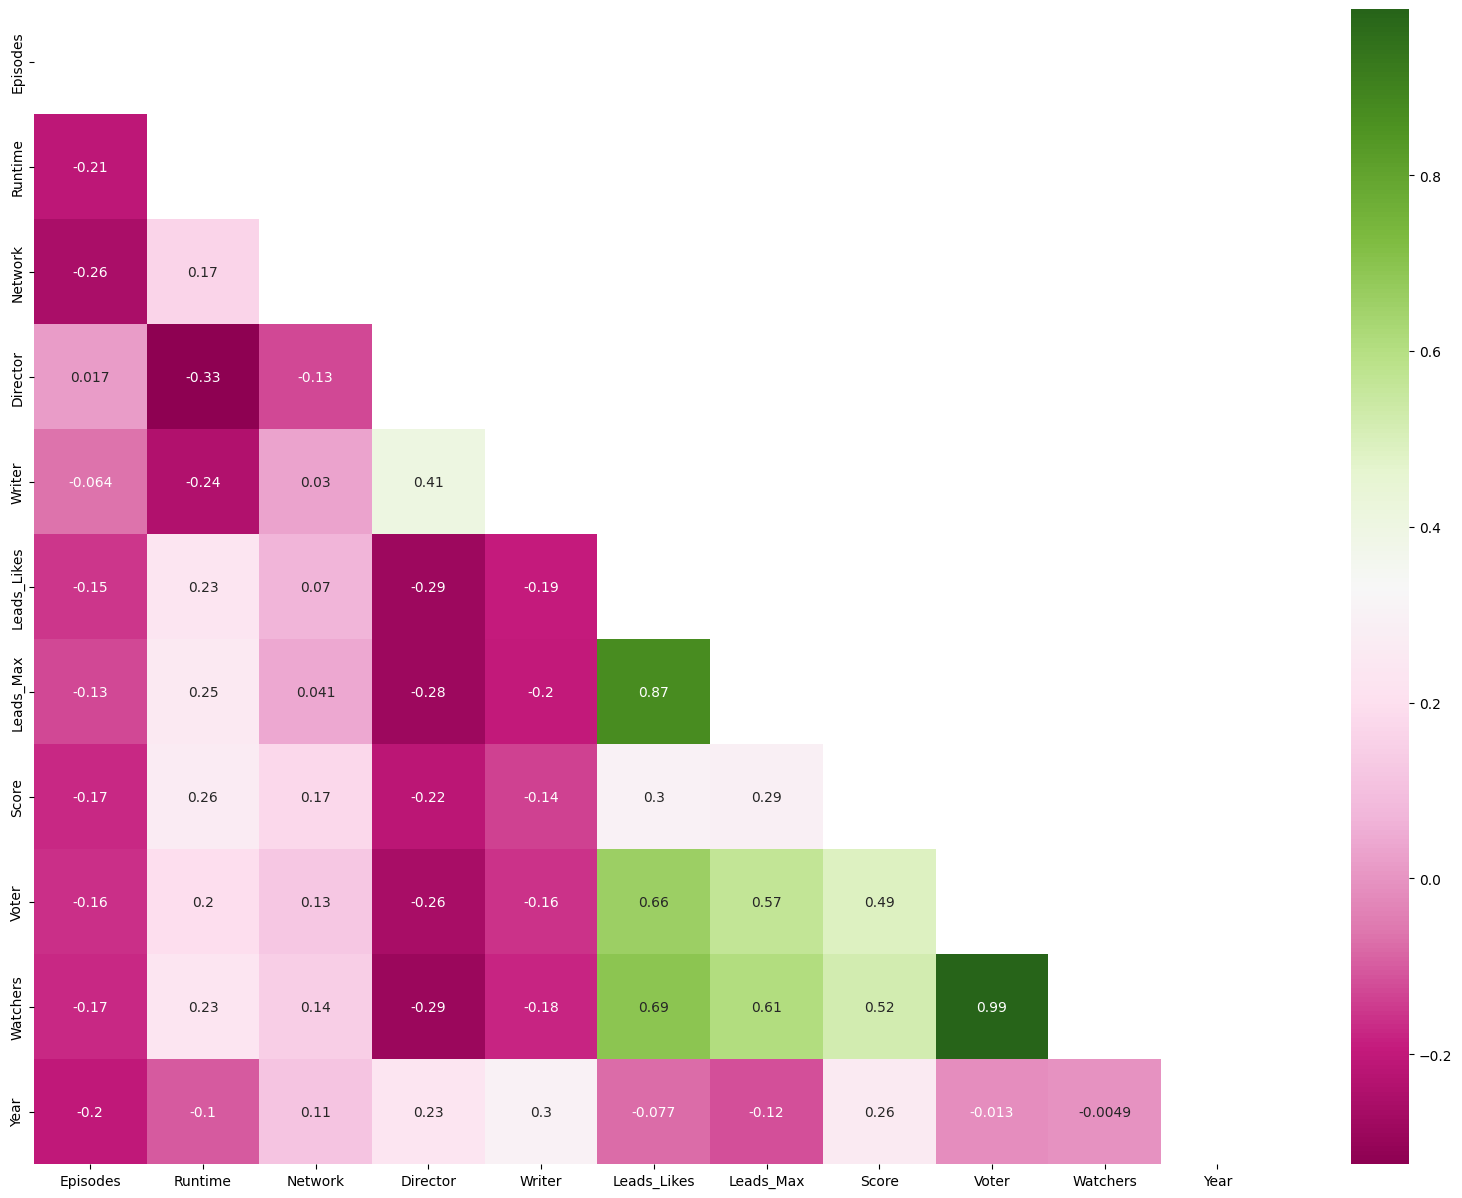

In [611]:
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
df.drop(columns=['Rank','Time Slot','URL','Title', 'Country','Leads','Tag'], inplace=True)
#print(df.isnull().sum())
newset = df.copy()
newset.dropna(inplace=True)
print(newset.shape)
newset['Year'] = newset['Premiere'].dt.year.astype('Int64')
newset.drop(columns=[ 'Finale','Premiere'], inplace=True)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cat_list = ['Director', 'Writer','Network'] #NEED TO CHANGE LEADS TO SEPERATE COLUMNS
newset[cat_list]=newset[cat_list].apply(lambda x:le.fit_transform(x))
heat = newset.drop(columns=h.columns)
print(heat.columns)
corr = heat.corr()
mask = np.zeros(corr.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True
plt.subplots(figsize=(20,15))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,cmap='PiYG',annot=True,mask = mask)

The average rating, labelled **Score**, doesn't have strong correlation with any of the predicators. **Watchers** and **Voters** have a moderate correlation. 

Looking at the heatmap above, a few features display a very strong correlation. These are:
* **Voters** and **Watchers**
* **Leads_Likes** and **Leads_Max**

These two sets of features are very strongly correlated. As a result, one of the pair can be dropped from the list of features. The correlation between **Voters** and **Watchers** can be explained by the proportion of watchers who also leave a rating being constant between dramas. The correlation between the likes of leads and the maximum likes is due to the low number of leads in a drama. 

There are also a strong correlations which will be examined:
* **Leads_Likes** and **Watchers**


Text(0, 0.5, 'Leads_Likes')

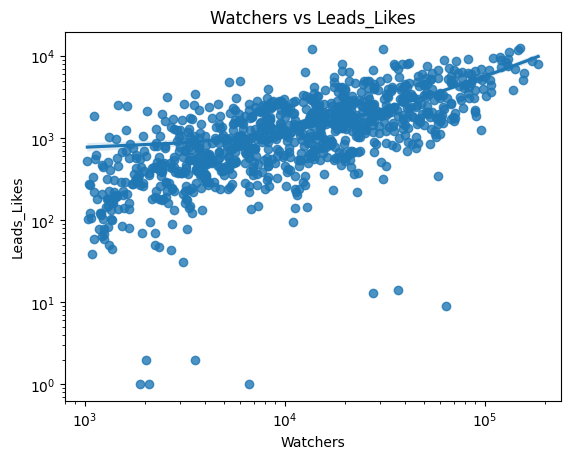

In [612]:
watchers_likes = sns.regplot(x='Watchers', y='Leads_Likes', data=newset)
watchers_likes.set(xscale="log", yscale="log")
plt.title('Watchers vs Leads_Likes')
plt.xlabel('Watchers')
plt.ylabel('Leads_Likes')

The above plot shows the strong correlation between the average likes on the leads' profiles and the amount of watchers of a drama. This is an expected result as the popularity of lead actors often drives viewership. The outliers in this plot might be a result of newer dramas, especially those released towards the tailend of 2022.

From the feature correlation, certain features should be dropped.

In [613]:
newset.drop(columns=['Leads_Max','Voter'], inplace=True)

## Predictive Model

The train/test split will be defined as 80-20. I will also standardize the predictive features. The scaling will be fitted from the training set and applied to both sets.

In [614]:
y=newset['Score']
x=newset.drop(columns=['Score'])
#x=newset.drop(columns=['Score','Leads_Likes']) 
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=9)
print(x_train.shape)
print(x_test.shape)
#Scaling predictive features
from sklearn.preprocessing import MinMaxScaler, StandardScaler
sc = StandardScaler()
#sc = MinMaxScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_train = pd.DataFrame(x_train, columns=x.columns)
x_test = pd.DataFrame(x_test, columns=x.columns)
print(x_train.columns)

(783, 55)
(196, 55)
Index(['Episodes', 'Runtime', 'Network', 'Director', 'Writer', 'Leads_Likes',
       'Watchers', ' Adventure', ' Business', ' Comedy', ' Crime',
       ' Documentary', ' Drama', ' Family', ' Fantasy', ' Historical',
       ' Horror', ' Law', ' Life', ' Martial Arts', ' Mature', ' Medical',
       ' Melodrama', ' Military', ' Mystery', ' Political', ' Psychological',
       ' Romance', ' Sci-Fi', ' Sitcom', ' Sports', ' Supernatural',
       ' Thriller', ' War', ' Youth', 'Action', 'Adventure', 'Business',
       'Comedy', 'Crime', 'Drama', 'Food', 'Friendship', 'Historical',
       'Horror', 'Law', 'Life', 'Military', 'Music', 'Mystery',
       'Psychological', 'Romance', 'Thriller', 'Youth', 'Year'],
      dtype='object')


### RidgeCV

R^2 Score for predictions: 0.5278378574199782
RMSE Score for predictions: 0.3857400104075584


Text(0.5, 1.0, 'Ratings vs Predicted Ratings')

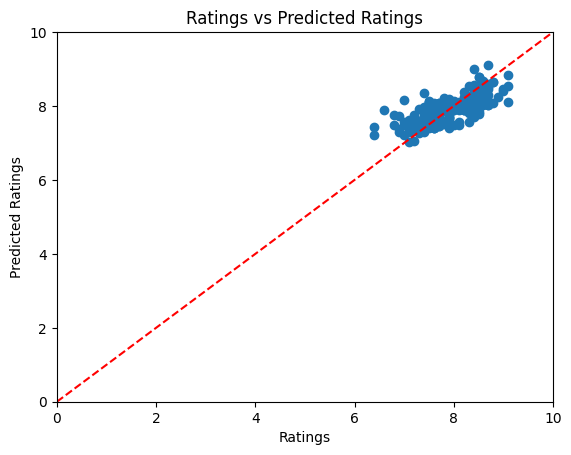

In [615]:
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
ridge_model = RidgeCV(cv=5,scoring='r2')
ridge_model.fit(x_train.values, y_train)
ridge_train = ridge_model.predict(x_train.values)
ridge_pred = ridge_model.predict(x_test.values)
ridge_train_r2 = r2_score(y_train, ridge_train)
ridge_test_r2 =r2_score(y_test, ridge_pred)
ridge_train_rmse = np.sqrt(mean_squared_error(y_train, ridge_train))
ridge_test_rmse = np.sqrt(mean_squared_error(y_test, ridge_pred))
print("R^2 Score for predictions:", ridge_test_r2)
print("RMSE Score for predictions:", ridge_test_rmse)

plt.axis([0,10,0,10])
plt.scatter(y_test, ridge_pred)
index_arr = [n for n in range(11)]
plt.plot(index_arr,'r--')             
plt.xlabel("Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Ratings vs Predicted Ratings")

Text(0.5, 1.0, 'Partial Residuals Plot')

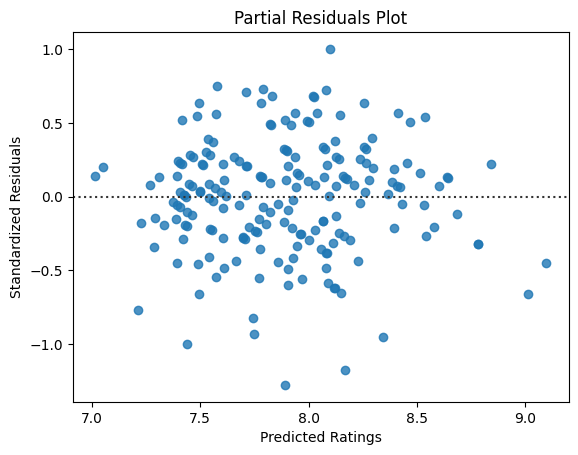

In [616]:
sns.residplot(x=ridge_pred, y=y_test, lowess=False)
plt.xlabel("Predicted Ratings")
plt.ylabel("Standardized Residuals")
plt.title("Partial Residuals Plot")

### LassoCV



R^2 Score for predictions: 0.5326696000652897
RMSE Score for predictions: 0.38376125246922854


Text(0.5, 1.0, 'Ratings vs Predicted Ratings')

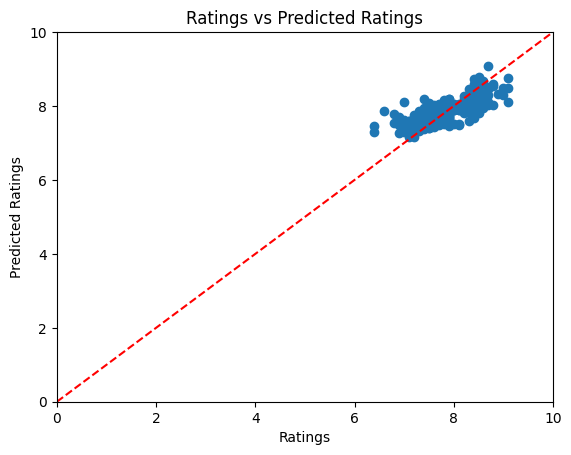

In [617]:
lasso_model = LassoCV(cv=5)
lasso_model.fit(x_train.values, y_train)
lasso_train = lasso_model.predict(x_train.values)
lasso_pred = lasso_model.predict(x_test.values)
lasso_train_r2 = r2_score(y_train, lasso_train)
lasso_test_r2 =r2_score(y_test, lasso_pred)
lasso_train_rmse = np.sqrt(mean_squared_error(y_train, lasso_train))
lasso_test_rmse = np.sqrt(mean_squared_error(y_test, lasso_pred))
print("R^2 Score for predictions:", lasso_test_r2)
print("RMSE Score for predictions:", lasso_test_rmse)

plt.axis([0,10,0,10])
plt.scatter(y_test, lasso_pred)
index_arr = [n for n in range(11)]
plt.plot(index_arr,'r--')             
plt.xlabel("Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Ratings vs Predicted Ratings")

Text(0.5, 1.0, 'Partial Residuals Plot')

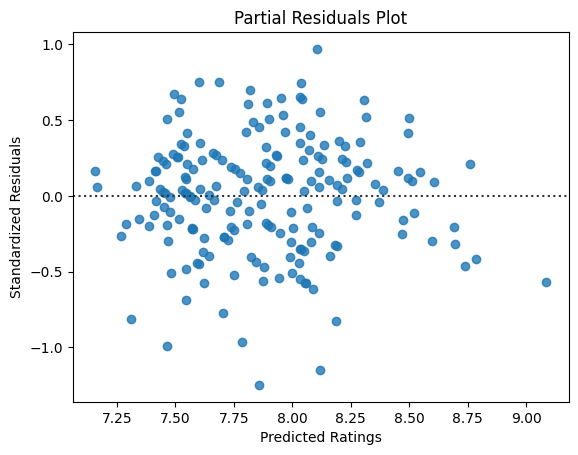

In [618]:
sns.residplot(x=lasso_pred, y=y_test, lowess=False)
plt.xlabel("Predicted Ratings")
plt.ylabel("Standardized Residuals")
plt.title("Partial Residuals Plot")

### RandomForest



R^2 Score for predictions: 0.606970270116229
RMSE Score for predictions: 0.3519344718111308


Text(0.5, 1.0, 'Movie ratings vs Predicted ratings')

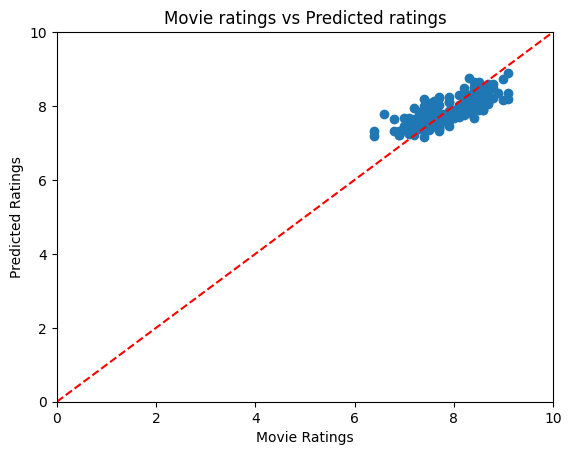

In [619]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=0)
rf_model.fit(x_train.values,y_train)
rf_train = rf_model.predict(x_train.values)
rf_pred = rf_model.predict(x_test.values)
rf_train_r2 = r2_score(y_train, rf_train)
rf_test_r2 =r2_score(y_test, rf_pred)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_train))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
print("R^2 Score for predictions:", rf_test_r2)
print("RMSE Score for predictions:", rf_test_rmse)

plt.axis([0,10,0,10])
plt.scatter(y_test, rf_pred)
index_arr = [n for n in range(11)]
plt.plot(index_arr,'r--')             
plt.xlabel("Movie Ratings")
plt.ylabel("Predicted Ratings")
plt.title("Movie ratings vs Predicted ratings")

Text(0.5, 1.0, 'Partial Residuals Plot')

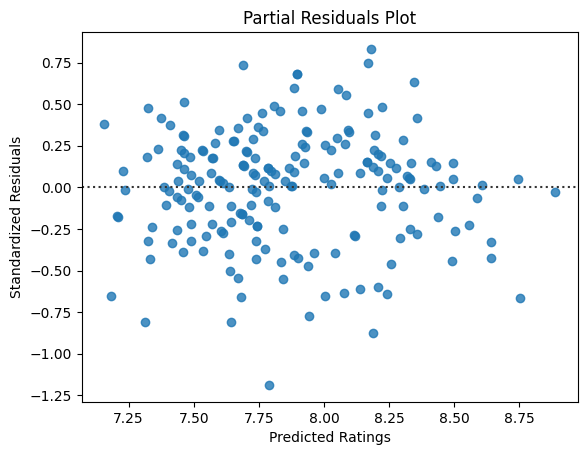

In [620]:
sns.residplot(x=rf_pred, y=y_test, lowess=False)
plt.xlabel("Predicted Ratings")
plt.ylabel("Standardized Residuals")
plt.title("Partial Residuals Plot")

### GridSearchCV Random Forest

### Regression Summary

Three different regression models were used. The residuals plots show no clear patterns, which is good. Looking at the evalution metrics, it appears that Random Forest Regression is the best based on R-squared and RMSE. The high training R-squared should be ignored due to predicting on the training set. Given that Test RMSEs > Train RMSEs, it seems the models have been overfitted. Overall, the models have a lot of room for improvement, although it is partially limited by the narrow range of ratings.

It would be interesting to compare these ratings with domestic ratings.

In [621]:
train_r2=[ridge_train_r2,lasso_train_r2,rf_train_r2]
test_r2=[ridge_test_r2,lasso_test_r2,rf_test_r2]

train_rmse=[ridge_train_rmse,lasso_train_rmse,rf_train_rmse]
test_rmse=[ridge_test_rmse,lasso_test_rmse,rf_test_rmse]

col={'Train R^2':train_r2,'Test R^2':test_r2, 'Train RMSE':train_rmse, 'Test RMSE': test_rmse}
models=['Ridge CV','LassoCV','Random Forest']
error_metrics=pd.DataFrame(data=col,index=models)
error_metrics

,Train R^2,Test R^2,Train RMSE,Test RMSE
Ridge CV,0.513486,0.527838,0.363693,0.385740
LassoCV,0.501216,0.532670,0.368251,0.383761
Random Forest,0.932754,0.606970,0.135213,0.351934


Looking at the feature importance, **Watchers** had the most importance. This was expected due the moderate correlation observed earlier. The effect of year is also relatively high which was also predicted earlier. This is expected due to the amount of time users have had to watch dramas including ones which were airing in December 2022.

In [622]:
features = pd.DataFrame(zip(x_train.columns, ridge_model.coef_, lasso_model.coef_, rf_model.feature_importances_))
features.columns = ['Feature','RidgeCV','LassoCV','Random_Forest']
features

,Feature,RidgeCV,LassoCV,Random_Forest
0,Episodes,0.012331,0.000000,3.556617e-02
1,Runtime,0.038860,0.037136,5.545232e-02
2,Network,0.011748,0.004716,3.528747e-02
3,Director,-0.023484,-0.021718,6.303073e-02
4,Writer,-0.041584,-0.032437,5.355837e-02
5,Leads_Likes,-0.061270,-0.039010,6.005571e-02
6,Watchers,0.284220,0.267927,4.418646e-01
7,Adventure,-0.011031,-0.000000,1.850862e-05
8,Business,-0.016070,-0.010944,5.022281e-04
9,Comedy,0.010050,-0.000000,5.711613e-03
